# Inference notenook for [CLIP prefix captioning](https://github.com/rmokady/CLIP_prefix_caption/)

Disclaimer: the authors do not own any rights for the code or data.

In [1]:
#@title Install
# !pip install transformers
# ! pip install git+https://github.com/openai/CLIP.git


In [2]:
# #@title Drive Downloader

# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# download_with_pydrive = True #@param {type:"boolean"}  

# class Downloader(object):
#     def __init__(self, use_pydrive):
#         self.use_pydrive = use_pydrive

#         if self.use_pydrive:
#             self.authenticate()
        
#     def authenticate(self):
#         auth.authenticate_user()
#         gauth = GoogleAuth()
#         gauth.credentials = GoogleCredentials.get_application_default()
#         self.drive = GoogleDrive(gauth)
    
#     def download_file(self, file_id, file_dst):
#         if self.use_pydrive:
#             downloaded = self.drive.CreateFile({'id':file_id})
#             downloaded.FetchMetadata(fetch_all=True)
#             downloaded.GetContentFile(file_dst)
#         else:
#             !gdown --id $file_id -O $file_dst

# downloader = Downloader(download_with_pydrive)

In [3]:
#@title Imports

import clip
import os
from torch import nn
import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
#from google.colab import files
import skimage.io as io
import PIL.Image
from IPython.display import Image 


N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]


D = torch.device
CPU = torch.device('cpu')


def get_device(device_id: int) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')


CUDA = get_device

current_directory = os.getcwd()
save_path = os.path.join(os.path.dirname(current_directory), "pretrained_models")
os.makedirs(save_path, exist_ok=True)
model_path = os.path.join(save_path, 'model_wieghts.pt')


In [4]:
#@title Model

class MLP(nn.Module):

    def forward(self, x: T) -> T:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class ClipCaptionModel(nn.Module):

    #@functools.lru_cache #FIXME
    def get_dummy_token(self, batch_size: int, device: D) -> T:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: T, prefix: T, mask: Optional[T] = None, labels: Optional[T] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        #print(embedding_text.size()) #torch.Size([5, 67, 768])
        #print(prefix_projections.size()) #torch.Size([5, 1, 768])
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, prefix_size: int = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

In [5]:
#@title Caption prediction

def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts


def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

In [6]:
#@title Choose pretrained model - COCO or Coneptual captions


# pretrained_model = 'Conceptual captions'  # @param ['COCO', 'Conceptual captions']

# if pretrained_model == 'Conceptual captions':
#   downloader.download_file("14pXWwB4Zm82rsDdvbGguLfx9F8aM7ovT", model_path)
# else:
#   downloader.download_file("1IdaBtMSvtyzF0ByVaBHtvM0JYSXRExRX", model_path)

In [7]:
#@title GPU/CPU


is_gpu = True #@param {type:"boolean"}  


In [8]:
#@title CLIP model + GPT2 tokenizer

device = CUDA(0) if is_gpu else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [9]:
#@title Load model weights


prefix_length = 10

model = ClipCaptionModel(prefix_length)

model.load_state_dict(torch.load(model_path, map_location=CPU)) 

model = model.eval() 
device = CUDA(0) if is_gpu else "cpu"
model = model.to(device)


In [10]:
# #@title Upload Image


# uploaded = files.upload()

# if not uploaded:
#   UPLOADED_FILE = ''
# elif len(uploaded) == 1:
#   UPLOADED_FILE = list(uploaded.keys())[0]
# else:
#   raise AssertionError('Please upload one image at a time')

# print(UPLOADED_FILE)

In [11]:
# #@title Or download random samples form COCO test set (Karpathy et al. split)

# IMAGE_NAME = '354533'  # @param ['562207', '579664', '060623', '165547', '334321', '483108', '386164', '354533']

# name_ = "COCO_val2014_000000" + IMAGE_NAME + ".jpg"
# images_path = os.path.join(os.path.dirname(current_directory), "images")
# os.makedirs(images_path, exist_ok=True)
# UPLOADED_FILE = os.path.join(images_path, name_)

# if not os.path.isfile(UPLOADED_FILE):
#   download_path = os.path.join(images_path, "images.zip")
#   downloader.download_file("1BwJeBME-dpwcCT8IXYeWz7uaPkbexjNB", download_path)

#   !unzip {download_path} -d {images_path}



Conceptual captions examples:
https://drive.google.com/file/d/1mzH3b0LQrGEWjEva4hI6HE_fIYRIgtBT/view?usp=sharing

## Test Block

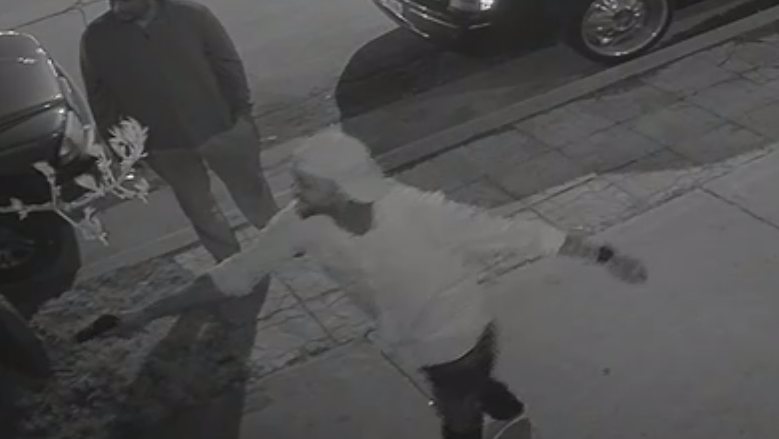

100%|██████████| 1/1 [00:00<00:00,  1.32it/s]



A person is holding a gun out in front of him in a building.


In [12]:
#@title Inference
use_beam_search = False #@param {type:"boolean"}  

image = io.imread('../all_images/shooting-suspect-3-1557755172.png')
pil_image = PIL.Image.fromarray(image)
#pil_img = Image(filename=UPLOADED_FILE)
display(pil_image)

image = preprocess(pil_image).unsqueeze(0).to(device)
with torch.no_grad():
    # if type(model) is ClipCaptionE2E:
    #     prefix_embed = model.forward_image(image)
    # else:
    prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
if use_beam_search:
    generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
else:
    generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)


print('\n')
print(generated_text_prefix)

## Test Block

# Loop Images and Find scores

In [13]:
image_files = os.listdir('../all_images')

In [14]:
captions_dict_list = []

In [15]:
#@title Inference
use_beam_search = True #@param {type:"boolean"}  

for filename in image_files:
  try:
    image = io.imread("../all_images/" + filename)
    pil_image = PIL.Image.fromarray(image)
    #pil_img = Image(filename=UPLOADED_FILE)
    #display(pil_image)

    image = preprocess(pil_image).unsqueeze(0).to(device)
    with torch.no_grad():
        # if type(model) is ClipCaptionE2E:
        #     prefix_embed = model.forward_image(image)
        # else:
        prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
        prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
    if use_beam_search:
        generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
    else:
        generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)


    #print('\n')
    #print(filename + "," + generated_text_prefix)
    captions_dict_list.append({"filename":filename, "caption": generated_text_prefix})
  except Exception as e:
    print(e)

Could not find a format to read the specified file in single-image mode


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


Could not find a format to read the specified file in single-image mode
Could not find a format to read the specified file in single-image mode
Could not find a format to read the specified file in single-image mode
Could not find a format to read the specified file in single-image mode
Could not find a format to read the specified file in single-image mode
Could not find a format to read the specified file in single-image mode
Could not find a format to read the specified file in single-image mode
Could not find a format to read the specified file in single-image mode
Could not find a format to read the specified file in single-image mode
Could not find a format to read the specified file in single-image mode
Could not find a format to read the specified file in single-image mode
Could not find a format to read the specified file in single-image mode
Could not find a format to read the specified file in single-image mode
Could not find a format to read the specified file in single-ima

In [16]:
import pandas as pd
df = pd.DataFrame(captions_dict_list)

In [17]:
df.head()

,filename,caption
0,01nyshooting-1-videoSixteenByNine3000.png,A man in a black hoodie points a gun at someon...
1,100419-kgo-babba-break-in-help-img_Image_17-00...,A person dressed in hoodie tries to break into...
2,11082118_100421-wls-alexis-austin-shootiout-ch...,A man in a white hoodie kneels down and points...
3,170108141724-fort-lauderdale-airport-shooting-...,A person in a blue shirt points a gun out in f...
4,180713_wabc_mob_hit_hpMain_16x9_992.jpeg,A man aims a gun at someone lying face down in...


In [18]:
#df.to_csv('finetuned_algo_captions.csv')

In [19]:
df_predicts = df

In [20]:
# !pip install transformers
# !pip install sentence-transformers

In [21]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

In [22]:
model = SentenceTransformer('stsb-roberta-large')

In [24]:
df_predicts.head()

,filename,caption
0,01nyshooting-1-videoSixteenByNine3000.png,A man in a black hoodie points a gun at someon...
1,100419-kgo-babba-break-in-help-img_Image_17-00...,A person dressed in hoodie tries to break into...
2,11082118_100421-wls-alexis-austin-shootiout-ch...,A man in a white hoodie kneels down and points...
3,170108141724-fort-lauderdale-airport-shooting-...,A person in a blue shirt points a gun out in f...
4,180713_wabc_mob_hit_hpMain_16x9_992.jpeg,A man aims a gun at someone lying face down in...


In [29]:
df_human_captions = pd.read_csv('clipclap_human_captions.csv')

In [36]:
df_human_captions = df_human_captions.drop('clip clap algo caption', axis=1)

In [38]:
df_human_captions.head()

,filename,human caption
0,01nyshooting-1-videoSixteenByNine3000.png,hooded and masked person pointing a gun at som...
1,100419-kgo-babba-break-in-help-img_Image_17-00...,hooded person peaking through back of a car wh...
2,11082118_100421-wls-alexis-austin-shootiout-ch...,person in the street pointing their gun at the...
3,170108141724-fort-lauderdale-airport-shooting-...,man pointing a gun at unknown object in an air...
4,1_THP_CHP_010622Slug_02471JPG.jpeg,group of people pointing their guns at unknown...


In [39]:
df_joined = pd.concat([df_predicts.set_index('filename'),df_human_captions.set_index('filename')], axis=1, join='inner').reset_index()

In [43]:
df_joined.head()

,filename,caption,human caption
0,01nyshooting-1-videoSixteenByNine3000.png,A man in a black hoodie points a gun at someon...,hooded and masked person pointing a gun at som...
1,100419-kgo-babba-break-in-help-img_Image_17-00...,A person dressed in hoodie tries to break into...,hooded person peaking through back of a car wh...
2,11082118_100421-wls-alexis-austin-shootiout-ch...,A man in a white hoodie kneels down and points...,person in the street pointing their gun at the...
3,170108141724-fort-lauderdale-airport-shooting-...,A person in a blue shirt points a gun out in f...,man pointing a gun at unknown object in an air...
4,1_THP_CHP_010622Slug_02471JPG.jpeg,Two persons are pointing guns near cars on the...,group of people pointing their guns at unknown...


In [45]:
sim_score_dicts_list = []

In [46]:
for index, row in df_joined.iterrows():
  try:
    # encode sentences to get their embeddings
    embedding1 = model.encode(row['human caption'], convert_to_tensor=True)
    embedding2 = model.encode(row['caption'], convert_to_tensor=True)
    #embedding3 = model.encode(row['algo caption (with beam search)'], convert_to_tensor=True)

    cosine_score_1 = util.pytorch_cos_sim(embedding1, embedding2)
    #cosine_score_2 = util.pytorch_cos_sim(embedding1, embedding3)

    #sim_score_dicts_list.append({"filename":row['file name'], "sim_score_without":cosine_score_1.item(), "sim_score_with":cosine_score_2.item()})
    sim_score_dicts_list.append({"filename":row['filename'], "sim_score_without":cosine_score_1.item()})

    #print("Similarity score:", cosine_score_1.item())
    #print("Similarity score 2:", cosine_score_2.item())
  except Exception as e:
    print(e)

In [47]:
df_sims = pd.DataFrame(sim_score_dicts_list)

In [27]:
#df_sims.to_csv('finetuned_sim_preds.csv')

In [48]:
df_sims.head()

,filename,sim_score_without
0,01nyshooting-1-videoSixteenByNine3000.png,0.723387
1,100419-kgo-babba-break-in-help-img_Image_17-00...,0.686923
2,11082118_100421-wls-alexis-austin-shootiout-ch...,0.576867
3,170108141724-fort-lauderdale-airport-shooting-...,0.470823
4,1_THP_CHP_010622Slug_02471JPG.jpeg,0.530352


# Bleu and Meteor Scores

In [50]:
import nltk
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [51]:
from nltk.translate.bleu_score import sentence_bleu

In [52]:
# Bleu Score Function
def calculate_bleu(ref, can):
  # print(ref)
  # print(can)
  # print()
  reference = [
      ref.split()
  ]
  candidate = can.split()
  return sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))

In [53]:
def calculate_meteor(ref,can):
  return nltk.translate.meteor_score.meteor_score([ref.split()], can.split())

In [54]:
bleu_meteor_score_dict_list = []

In [55]:
for index, row in df_joined.iterrows():
  if type(row['caption']) == str:    
    bleu_score = '%f' % calculate_bleu(row['human caption'], row['caption'])    
    meteor_score = '%f' % calculate_meteor(row['human caption'], row['caption'])
    #print('%f' % calculate_bleu(row['human caption'], row['algo caption (w/o beam search)']))
    bleu_meteor_score_dict_list.append({'filename': row['filename'],'bleu_score': bleu_score,'meteor_score': meteor_score})

/home/azureuser/.local/lib/python3.6/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/azureuser/.local/lib/python3.6/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/azureuser/.local/lib/python3.6/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use Smoo

In [57]:
df_van_bleu_scores = pd.DataFrame(bleu_meteor_score_dict_list)

In [58]:
df_van_bleu_scores.head()

,filename,bleu_score,meteor_score
0,01nyshooting-1-videoSixteenByNine3000.png,0.186125,0.249485
1,100419-kgo-babba-break-in-help-img_Image_17-00...,0.250000,0.218978
2,11082118_100421-wls-alexis-austin-shootiout-ch...,0.200000,0.239110
3,170108141724-fort-lauderdale-airport-shooting-...,0.176471,0.160000
4,1_THP_CHP_010622Slug_02471JPG.jpeg,0.200000,0.109890


In [59]:
# Final Results
df_final_results = pd.concat([df_sims.set_index('filename'),df_van_bleu_scores.set_index('filename')], axis=1, join='inner').reset_index()

In [60]:
df_final_results.head()

,filename,sim_score_without,bleu_score,meteor_score
0,01nyshooting-1-videoSixteenByNine3000.png,0.723387,0.186125,0.249485
1,100419-kgo-babba-break-in-help-img_Image_17-00...,0.686923,0.250000,0.218978
2,11082118_100421-wls-alexis-austin-shootiout-ch...,0.576867,0.200000,0.239110
3,170108141724-fort-lauderdale-airport-shooting-...,0.470823,0.176471,0.160000
4,1_THP_CHP_010622Slug_02471JPG.jpeg,0.530352,0.200000,0.109890


In [61]:
df_final_results.to_csv('cs229_sim_bleu_meteor_finetune1.csv')